# Stock Portfolio Optimizer with PyPortfolioOpt 

In this project I will fetch stock prices data of stocks that we are interested to include in portfolio and analyze it by looking at the stock returns, volatility, Sharpe ratio, the Modern Portfolio Theory(?) and efficient frontier. And then use PyPortfolioOpt for portfolio optimization purposes and get the optimized weight spread and portfolio performance. 

## Initial Imports

Remember to do pip installs for the following libraries if you do not already have them (pandas-datareader, PyPortfolioOpt and, plotly

In [27]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly
import plotly.express as px
import plotly.graph_objects as go
import math
import seaborn as sns
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting

from tqdm import tqdm 


## Pull Stock Prices Via Yahoo Finance Library

Found these 5 stocks ['OXY', 'GM', 'PSTG', 'TXRH', 'ENPH'] that are highly recommended by investors to buy and watch. Here is the article: https://www.investors.com/research/best-stocks-to-buy-now/. However, you can change them to the ones you are interested to fetch.

In [28]:
stocks_data = yf.download(  
    
        #tickers = "OXY GM PSTG TXRH ENPH",
        #tickers = "AMZN BABA LAD PYPL TROW TSLA ZG ALL GPN KWEB MLPA VTWO",
        tickers = "MA V AMZN JPM BA",
    
        period = "max",

        interval = "1d",

        # Whether to ignore timezone when aligning ticker data from 
        # different timezones. Default is True.
        ignore_tz = False,

        group_by = 'ticker',
        

        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = True,

        # attempt repair of missing data or currency mixups e.g. $/cents
        repair = False,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use when downloading?
        # (optional, default is None)
        proxy = None
    )

stocks_data

[*********************100%***********************]  5 of 5 completed


V                                                  \
                  Open        High         Low       Close      Volume   
Date                                                                     
1962-01-02         NaN         NaN         NaN         NaN         NaN   
1962-01-03         NaN         NaN         NaN         NaN         NaN   
1962-01-04         NaN         NaN         NaN         NaN         NaN   
1962-01-05         NaN         NaN         NaN         NaN         NaN   
1962-01-08         NaN         NaN         NaN         NaN         NaN   
...                ...         ...         ...         ...         ...   
2023-01-09  219.070007  222.210007  218.350006  218.600006   6294500.0   
2023-01-10  218.990005  222.389999  218.179993  221.089996  10857000.0   
2023-01-11  221.289993  222.179993  219.699997  222.100006   5408200.0   
2023-01-12  222.100006  223.809998  220.610001  223.619995   4264400.0   
2023-01-13  221.910004  223.304993  220.139999  223.270401   2991206.0   

                    MA                                                 ...  \
                  Open        High         Low       Close     Volume  ...   
Date                                                                   ...   
1962-01-02         NaN         NaN         NaN         NaN        NaN  ...   
1962-01-03         NaN         NaN         NaN         NaN        NaN  ...   
1962-01-04         NaN         NaN         NaN         NaN        NaN  ...   
1962-01-05         NaN         NaN         NaN         NaN        NaN  ...   
1962-01-08         NaN         NaN         NaN         NaN        NaN  ...   
...                ...         ...         ...         ...        ...  ...   
2023-01-09  371.630005  375.000000  369.559998  370.970001  3913500.0  ...   
2023-01-10  368.809998  371.679993  367.209991  371.010010  3485900.0  ...   
2023-01-11  372.619995  377.920013  371.260010  377.859985  3370200.0  ...   
2023-01-12  377.859985  381.130005  376.920013  379.809998  3291200.0  ...   
2023-01-13  375.059998  377.869995  374.369995  376.119995  3117710.0  ...   

                 AMZN                                                \
                 Open       High        Low      Close       Volume   
Date                                                                  
1962-01-02        NaN        NaN        NaN        NaN          NaN   
1962-01-03        NaN        NaN        NaN        NaN          NaN   
1962-01-04        NaN        NaN        NaN        NaN          NaN   
1962-01-05        NaN        NaN        NaN        NaN          NaN   
1962-01-08        NaN        NaN        NaN        NaN          NaN   
...               ...        ...        ...        ...          ...   
2023-01-09  87.459999  89.480003  87.080002  87.360001   65266100.0   
2023-01-10  87.570000  90.190002  87.290001  89.870003   67756600.0   
2023-01-11  90.930000  95.260002  90.930000  95.089996  103126200.0   
2023-01-12  96.930000  97.190002  93.500000  95.269997   85254800.0   
2023-01-13  94.180000  98.355003  94.150002  98.120003   68693699.0   

                    BA                                               
                  Open        High         Low       Close   Volume  
Date                                                                 
1962-01-02    0.194272    0.194272    0.190931    0.190931   352350  
1962-01-03    0.193795    0.197614    0.193795    0.194750   710775  
1962-01-04    0.194749    0.198091    0.192840    0.192840   911250  
1962-01-05    0.192840    0.193795    0.183771    0.189022   880875  
1962-01-08    0.189022    0.192363    0.186635    0.189499   473850  
...                ...         ...         ...         ...      ...  
2023-01-09  212.360001  213.880005  207.910004  208.570007  9005600  
2023-01-10  203.899994  209.600006  203.460007  206.690002  8183200  
2023-01-11  209.869995  210.470001  206.690002  208.029999  7190700  
2023-01-12  209.580002  214.919998  207.369995  214.3200

## Stock Prices Comparison

In [29]:
stocks_df = stocks_data.iloc[:, stocks_data.columns.get_level_values(1)=='Close']
stocks_df.columns = stocks_df.columns.droplevel(1)
stocks_df

V          MA         JPM       AMZN          BA
Date                                                                 
1962-01-02         NaN         NaN         NaN        NaN    0.190931
1962-01-03         NaN         NaN         NaN        NaN    0.194750
1962-01-04         NaN         NaN         NaN        NaN    0.192840
1962-01-05         NaN         NaN         NaN        NaN    0.189022
1962-01-08         NaN         NaN         NaN        NaN    0.189499
...                ...         ...         ...        ...         ...
2023-01-09  218.600006  370.970001  137.369995  87.360001  208.570007
2023-01-10  221.089996  371.010010  138.600006  89.870003  206.690002
2023-01-11  222.100006  377.859985  139.630005  95.089996  208.029999
2023-01-12  223.619995  379.809998  139.490005  95.269997  214.320007
2023-01-13  223.270401  376.119995  143.050003  98.120003  213.979996

[15365 rows x 5 columns]

## Detect Missing Values & Clean Data

In [30]:
def get_empty_rows(dataset):
    # Nested 'for' loop and unique value list of 'set'
    return list(set([i for i, s in dataset.iterrows() for v in s.values if str(v) == 'nan']))

In [31]:
list_of_empty_rows = get_empty_rows(stocks_df)
stocks_df = stocks_df.drop(list_of_empty_rows)

In [32]:
stocks_df

V          MA         JPM       AMZN          BA
Date                                                                 
2008-03-19   12.752565   19.360554   28.923721   3.508500   54.094547
2008-03-20   14.524383   20.474493   31.307369   3.659500   55.088783
2008-03-24   13.481609   20.114010   31.702381   3.797500   56.186150
2008-03-25   14.276105   20.901850   31.368652   3.758500   55.898926
2008-03-26   14.436355   20.703968   30.040625   3.690000   56.193531
...                ...         ...         ...        ...         ...
2023-01-09  218.600006  370.970001  137.369995  87.360001  208.570007
2023-01-10  221.089996  371.010010  138.600006  89.870003  206.690002
2023-01-11  222.100006  377.859985  139.630005  95.089996  208.029999
2023-01-12  223.619995  379.809998  139.490005  95.269997  214.320007
2023-01-13  223.270401  376.119995  143.050003  98.120003  213.979996

[3733 rows x 5 columns]

In [33]:
#stocks_df = stocks_df.fillna(0)
#stocks_df = stocks_df.dropna(axis='rows')

#stocks_df.isnull().sum()

In [34]:
#stocks_df.head()

## Plot Stock Prices via Plotly

Plotly library allows us to make the graph interactive unlike Matplotlib

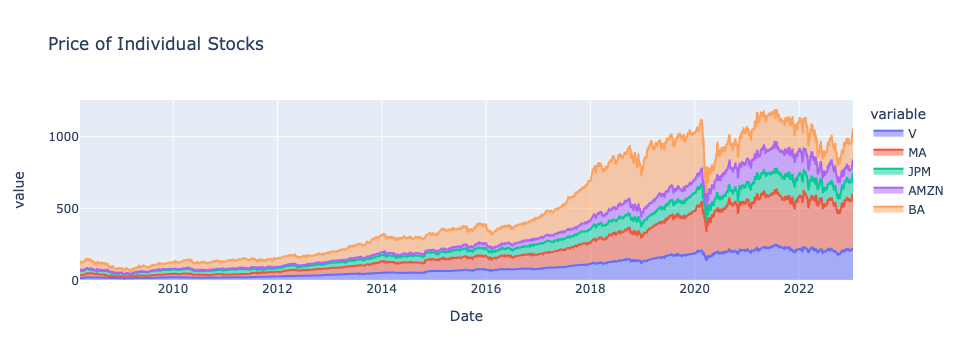

In [35]:
plot_indiv = px.area(stocks_df, facet_col_wrap=2, title='Price of Individual Stocks')
plot_indiv.show()

We can see that ENPH, TXRH, ENPH are dominating the graph scale, while the graphs of other stocks are more on flat side. However, its never an ideal way to judge stock performance and this is why we will examine daily returns and stock volatility. 

## Daily Returns

In [36]:
daily_returns = stocks_df.pct_change().dropna()
daily_returns = daily_returns[1:]
daily_returns.head()

V        MA       JPM      AMZN        BA
Date                                                        
2008-03-24 -0.071795 -0.017606  0.012617  0.037710  0.019920
2008-03-25  0.058932  0.039169 -0.010527 -0.010270 -0.005112
2008-03-26  0.011225 -0.009467 -0.042336 -0.018225  0.005270
2008-03-27 -0.016417 -0.009648 -0.028338 -0.040650 -0.027261
2008-03-28 -0.002384 -0.014046 -0.003500 -0.014689 -0.010105

In [37]:
daily_returns.tail()

V        MA       JPM      AMZN        BA
Date                                                        
2023-01-09  0.003904  0.008975 -0.004132  0.014870 -0.020798
2023-01-10  0.011391  0.000108  0.008954  0.028732 -0.009014
2023-01-11  0.004568  0.018463  0.007431  0.058084  0.006483
2023-01-12  0.006844  0.005161 -0.001003  0.001893  0.030236
2023-01-13 -0.001563 -0.009715  0.025522  0.029915 -0.001586

## Cumulative Returns

Last row of the dataframe multiplied by 100 is giving us the percentage change of the stock prices for our entire period (2015-10-06 to current)

In [38]:
df_cum_daily_returns = (1 + daily_returns).cumprod() - 1
df_cum_daily_returns = df_cum_daily_returns.reset_index()
df_cum_daily_returns

Date          V         MA       JPM       AMZN        BA
0    2008-03-24  -0.071795  -0.017606  0.012617   0.037710  0.019920
1    2008-03-25  -0.017094   0.020873  0.001957   0.027053  0.014706
2    2008-03-26  -0.006061   0.011208 -0.040462   0.008335  0.020054
3    2008-03-27  -0.022378   0.001452 -0.067653  -0.032655 -0.007754
4    2008-03-28  -0.024709  -0.012615 -0.070916  -0.046864 -0.017781
...         ...        ...        ...       ...        ...       ...
3726 2023-01-09  14.050554  17.118642  3.387785  22.872115  2.786070
3727 2023-01-10  14.221989  17.120596  3.427073  23.558001  2.751944
3728 2023-01-11  14.291528  17.455157  3.459972  24.984424  2.776268
3729 2023-01-12  14.396179  17.550398  3.455501  25.033611  2.890447
3730 2023-01-13  14.372110  17.370174  3.569212  25.812408  2.884275

[3731 rows x 6 columns]

In [39]:
cum_returns_whole_period = df_cum_daily_returns.iloc[:, 1:].tail(1)

cum_returns_whole_period * 100

V           MA         JPM         AMZN          BA
3730  1437.21096  1737.017379  356.921187  2581.240767  288.427522

## Visualize Daily Returns via Plotly

I will use the interactive library plotly.express, which would allow interacting with the graph: zooming in and out, adding/removing a plot line, saving as image and more.

plotly.express works with pandas dataframes in long format and we will use the function melt to transform our dataframes daily_returns and cum_returns from short format (we have the tickers as columns) to long format (tickers as rows).

In [40]:
# reset the index, moving `date` as column
daily_returns = daily_returns.reset_index()
# use `melt`
df1 = daily_returns.melt(id_vars=['Date'], var_name='ticker', value_name='daily_return')
# add one more column, showing the daily_return as percent
df1['daily_return_pct'] = df1['daily_return'] * 100
df1

Date ticker  daily_return  daily_return_pct
0     2008-03-24      V     -0.071795         -7.179467
1     2008-03-25      V      0.058932          5.893181
2     2008-03-26      V      0.011225          1.122503
3     2008-03-27      V     -0.016417         -1.641652
4     2008-03-28      V     -0.002384         -0.238443
...          ...    ...           ...               ...
18650 2023-01-09     BA     -0.020798         -2.079809
18651 2023-01-10     BA     -0.009014         -0.901378
18652 2023-01-11     BA      0.006483          0.648312
18653 2023-01-12     BA      0.030236          3.023606
18654 2023-01-13     BA     -0.001586         -0.158647

[18655 rows x 4 columns]

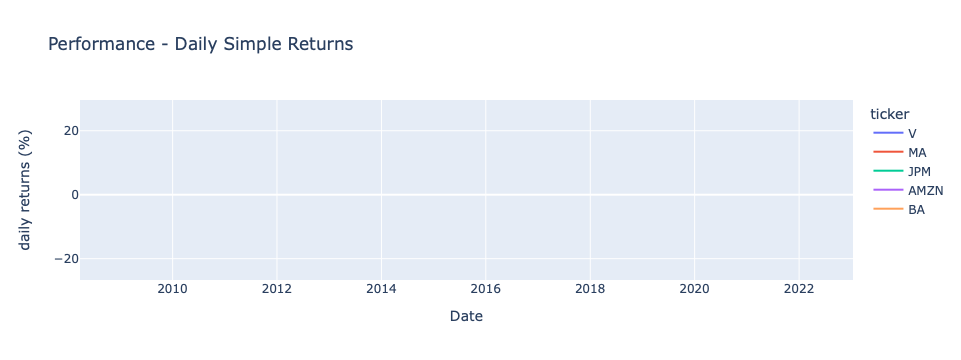

In [41]:
fig = px.line(df1, x='Date',
              y='daily_return_pct', color='ticker',
              title='Performance - Daily Simple Returns',
              labels={'daily_return_pct':'daily returns (%)' ,})
fig.show()

## Transforming the cumulative returns data for plotting.

In [42]:

df2 = df_cum_daily_returns.melt(id_vars=['Date'], var_name='ticker', value_name='cum_return')
df2['cum_return_pct'] = df2['cum_return'] * 100
df2

Date ticker  cum_return  cum_return_pct
0     2008-03-24      V   -0.071795       -7.179467
1     2008-03-25      V   -0.017094       -1.709385
2     2008-03-26      V   -0.006061       -0.606070
3     2008-03-27      V   -0.022378       -2.237773
4     2008-03-28      V   -0.024709       -2.470880
...          ...    ...         ...             ...
18650 2023-01-09     BA    2.786070      278.607032
18651 2023-01-10     BA    2.751944      275.194350
18652 2023-01-11     BA    2.776268      277.626781
18653 2023-01-12     BA    2.890447      289.044729
18654 2023-01-13     BA    2.884275      288.427522

[18655 rows x 4 columns]

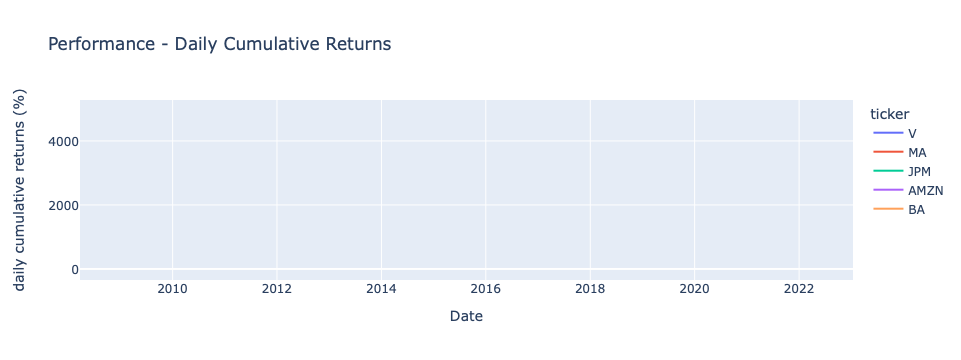

In [43]:
fig = px.line(df2, x='Date',
              y='cum_return_pct', color='ticker',
              title='Performance - Daily Cumulative Returns',
              labels={'cum_return_pct':'daily cumulative returns (%)', })
fig.show()

## Daily/Monthly/Annual Volatility

Standard deviation provides an intuition of how much a stock price differs from its average value over a specific period. It measures how far the stock price is from its average price. The higher the standard deviation, the greater moves away from the mean in the period. The higher the standard deviation, the greater the volatility of the stock. On the other hand, a lower standard deviation means that the prices in the given period should be close to the average price of the stock. This can be considered a good measure of risk.


Market volatility refers to price movements of a stock over a period and one of the ways to measure it is through standard deviation. Through standard deviation, we can find out by how much the stock can deviate from its average price in a given period. 

In [44]:
#Drop Date column in Daily Returns Dataframe
daily_returns = daily_returns.drop(columns = ['Date'])

#Calculating Daily Standard Deviation
daily_volatility = np.std(daily_returns)

#Converting Float Type to Dictionary
daily_volatility_dict = daily_volatility.to_dict()

#Creating a Volatility DataFrame 
volatility_df = pd.DataFrame.from_dict(daily_volatility_dict, orient='index',columns = ['Daily_Volatility'] ) 

#Adding and Calculating Monthly Volatility
volatility_df['Monthly_Volatility'] = math.sqrt(21) * volatility_df['Daily_Volatility']

#Adding and Calculating Annual Volatility
volatility_df['Annual_Volatility'] = math.sqrt(252) * volatility_df['Daily_Volatility']

volatility_df

Daily_Volatility  Monthly_Volatility  Annual_Volatility
V             0.018837            0.086322           0.299029
MA            0.020684            0.094787           0.328350
JPM           0.025115            0.115090           0.398683
AMZN          0.023580            0.108059           0.374327
BA            0.023733            0.108759           0.376753

In [45]:
volatility_df.sort_values(by = ['Annual_Volatility'], ascending = False)

Daily_Volatility  Monthly_Volatility  Annual_Volatility
JPM           0.025115            0.115090           0.398683
BA            0.023733            0.108759           0.376753
AMZN          0.023580            0.108059           0.374327
MA            0.020684            0.094787           0.328350
V             0.018837            0.086322           0.299029

## Correlation Matrix

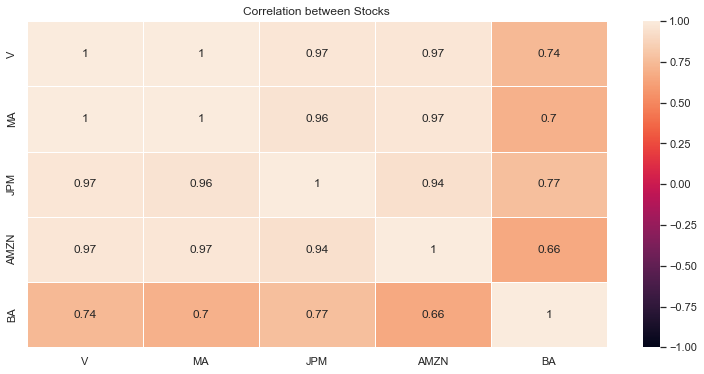

In [46]:
stock_correlation = stocks_df.corr().round(2)
sns.heatmap(stock_correlation, vmin=-1, vmax=1, annot = True, linewidth=.5).set(title = 'Correlation between Stocks')
sns.set(rc={"figure.figsize":(13, 6)})

____ stock would be the best candidate to add to the existing portfolio as it is the stock that has the least correlation with BMO and CNQ.

## Expected Returns and Covariance Matrix

In [47]:
expected_returns = expected_returns.mean_historical_return(stocks_df)
covarience = risk_models.sample_cov(stocks_df)
print(expected_returns)

V       0.213244
MA      0.221796
JPM     0.113980
AMZN    0.252226
BA      0.097303
dtype: float64


## Portfolio Returns, Risk Free Rate, Volatility and the Sharpe Ratio


Following a Monte Carlo approach, where a thousand randomly weighted portfolios are generated and from them we can decern efficient frontier 

In [48]:
# Number of assets to include in each portfolio 
num_assets = 5

# Number of portfolios to sample
num_portfolios = 1000

# Empty list to store mean-variance pairs
mean_variance_pairs = []

#For reproducibility
np.random.seed(75)

# Loop and generate portfolios
for i in range(num_portfolios):
    
    #Choose assets randomly without replacement
    assets = np.random.choice(list(stocks_df.columns), num_assets, replace = False)
    
    #Choose weights randomly
    weights = np.random.rand(num_assets)
    
    #Ensure weights sum up to 1 
    weights = weights/sum(weights)
    
    
    #Computing portfolio return and variance 
    portfolio_return = 0
    portfolio_variance = 0
    
    for i in range(len(assets)):
        portfolio_return += weights [i] * expected_returns.loc[assets[i]]
        
        for j in range(len(assets)):
            portfolio_variance += weights[i]* weights[j] * covarience.loc[assets[i],assets[j]]
    #Append to the list
    
    mean_variance_pairs.append([portfolio_return,portfolio_variance])
    

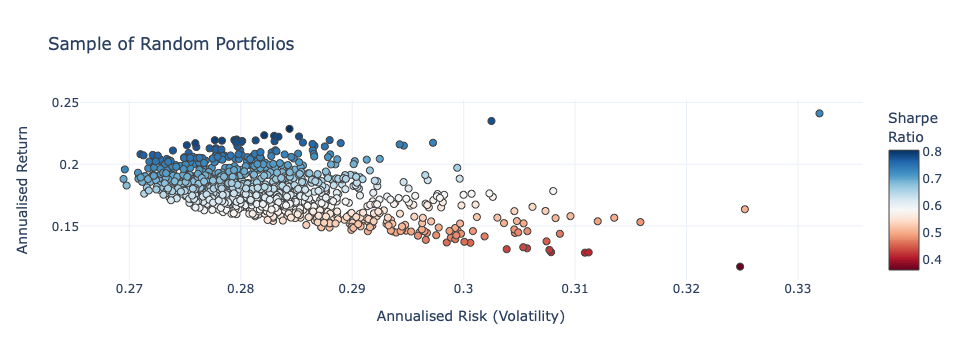

In [49]:
#-- Plot the risk vs. return of randomly generated portfolios
#- Convert the list from before into an array for easy plotting
mean_variance_pairs = np.array(mean_variance_pairs)
risk_free_rate=0 #-- Include risk free rate here for sharpe ratio

#-- Create Plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=mean_variance_pairs[:,1]**0.5, 
                         y=mean_variance_pairs[:,0], 
                      #- Add color scale for sharpe ratio   
                      marker=dict(color=(mean_variance_pairs[:,0]-risk_free_rate)/(mean_variance_pairs[:,1]**0.5), 
                                  showscale=True, 
                                  size=7,
                                  line=dict(width=1),
                                  colorscale="RdBu",
                                  colorbar=dict(title="Sharpe<br>Ratio")
                                 ), 
                      mode='markers'))
#- Add title/labels
fig.update_layout(template='plotly_white',
                  xaxis=dict(title='Annualised Risk (Volatility)'),
                  yaxis=dict(title='Annualised Return'),
                  title='Sample of Random Portfolios',
                  coloraxis_colorbar=dict(title="Sharpe Ratio"))